In [1]:
%matplotlib inline
'''

'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import BSpline, splrep

import dill

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution,\
                                    trans_cnumber, trans_product_mole
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF# , check_violate_constraint
from utility.data_utility import cal_cnumber, cal_MW
from utility.time_utility import create_filename_time, log_now, log_end

from data.thermal_data import Tb

2018-07-09 23:10:53 - Start Program


In [2]:
with open('./log/model/stage_20_optimized.pickle','rb') as f:
    model_solved = dill.load(f)

In [ ]:
    # mole fraction
    product_x = {i:model.reboiler.x[i].value / (sum(model.reboiler.x[i].value for i in m.COMP_ORG)) for i in m.COMP_ORG}
    # molar volume cm3/gmole
    product_V = {i:model.reboiler.VLE_block.V_L[i].value for i in m.COMP_ORG}

In [23]:
def get_TBP_D86(model,j):
    TBP = {}
    D86 = {}
    cnumber_range = range(1,57)
    # component boiling point, in C and F
    product_boiling = [[i,Tb[i] - 273.15,(Tb[i] - 273.15)*1.8 + 32,Tb[i]] for i in m.COMP_SORTED_BP]

    if j == 'condenser':
        # mole fraction
        product_x = {i:model.condenser.x[i].value / (sum(model.condenser.x[i].value for i in m.COMP_ORG)) for i in m.COMP_ORG}
        # molar volume cm3/gmole
        product_V = {i:model.condenser.VLE_block.V_L[i].value for i in m.COMP_ORG}        
    
    elif j == 'reboiler':       
        # mole fraction
        product_x = {i:model.reboiler.x[i].value / (sum(model.reboiler.x[i].value for i in m.COMP_ORG)) for i in m.COMP_ORG}
        # molar volume cm3/gmole
        product_V = {i:model.reboiler.VLE_block.V_L[i].value for i in m.COMP_ORG}
    
    else: 
        # mole fraction
        product_x = {i:model.reactive[j].x[i].value / (sum(model.reactive[j].x[i].value for i in m.COMP_ORG)) for i in m.COMP_ORG}
        # molar volume cm3/gmole
        product_V = {i:model.reactive[j].VLE_block.V_L[i].value for i in m.COMP_ORG}

    total_vol = sum(product_x[i]*product_V[i] for i in m.COMP_ORG)
    vol_tmp = 0
    
    TBP['vol'] = []
    TBP['C'] = []
    TBP['F'] = []
    D86['vol'] = []
    D86['C'] = []
    D86['F'] = []   

    for i,TC,TF,TK in product_boiling:
        TBP['C'].append(TC)
        TBP['F'].append(TF)
        TBP['vol'].append(vol_tmp)
        D86['vol'].append(vol_tmp)
        vol_tmp += product_x[i]*product_V[i]/total_vol
        
        if vol_tmp <= 0.1:
            TK_D86 = 1.08947*TK**0.99810
        elif vol_tmp <= 0.3:
            TK_D86 = 1.71243*TK**0.91743
        elif vol_tmp <= 0.5:
            TK_D86 = 1.29838*TK**0.95923
        elif vol_tmp <= 0.7:
            TK_D86 = 1.10755*TK**0.98270
        elif vol_tmp <= 0.9:
            TK_D86 = 1.13047*TK**0.97790
        elif vol_tmp <= 0.95:
            TK_D86 = 1.04643*TK**0.98912
        else:
            TK_D86 = 1.21455*TK**0.96572
            
        D86['C'].append(TK_D86-273.15)
        D86['F'].append((TK_D86-273.15)*1.8+32)
        
        if vol_tmp > 0.995:
            break
        
    return TBP, D86

### Product Distillation Curve

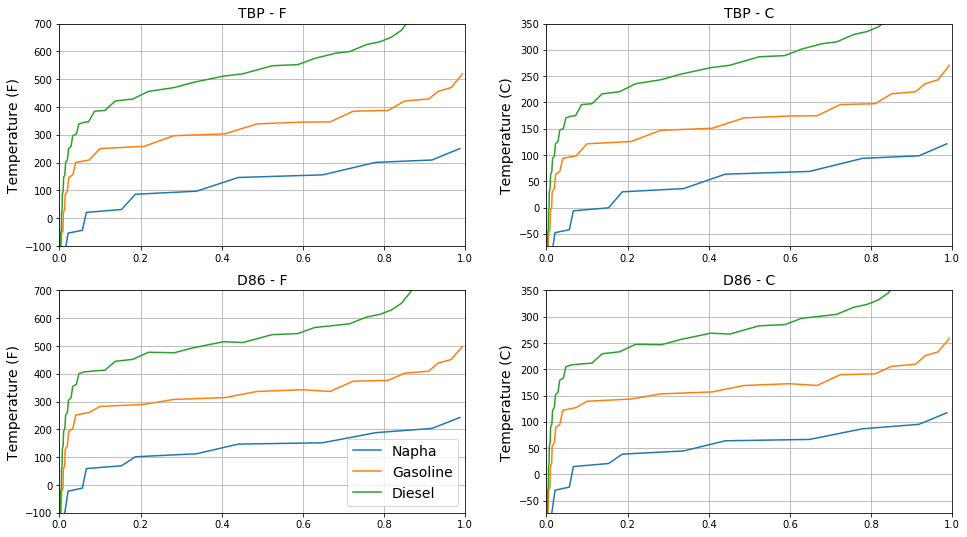

In [37]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,9))
for j in ['condenser',7,10]:
    
    TBP,D86 = get_TBP_D86(model_solved,j)
    ax1.plot(TBP['vol'],TBP['F'])
    ax1.set_ylim(-100,700)
    ax2.plot(TBP['vol'],TBP['C'])
    ax2.set_ylim(-73,350)
    
    ax3.plot(D86['vol'],D86['F'])
    ax3.set_ylim(-100,700)
    ax4.plot(D86['vol'],D86['C'])
    ax4.set_ylim(-73,350)

ax1.set_title('TBP - F',fontsize=14)
ax1.set_ylabel('Temperature (F)',fontsize=14)
ax1.set_xlim(0,1)
ax2.set_title('TBP - C',fontsize=14)
ax2.set_ylabel('Temperature (C)',fontsize=14)
ax2.set_xlim(0,1)
ax1.grid()
ax2.grid()

ax3.set_title('D86 - F',fontsize=14)
ax3.set_ylabel('Temperature (F)',fontsize=14)
ax3.set_xlim(0,1)
ax3.legend(['Napha','Gasoline','Diesel'],loc='lower right',fontsize=14)
ax4.set_title('D86 - C',fontsize=14)
ax4.set_ylabel('Temperature (C)',fontsize=14)
ax4.set_xlim(0,1)
ax3.grid()
ax4.grid()

plt.show()